## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing
import networkx as nx

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

First we need to load the data in variable and split the data into two groups: one for the people that got the training and one for those who dit not. From now on, all the references to the trained people will be showed by 'NSW' and the untrained will be 'PSID'.

In [2]:
#load the data
data = pd.read_csv("lalonde.csv")
#we create a column to have for each line the name of its group, we crate a new column so that later we can use the 
#column treat for some calcul.
data['group'] = data['treat'].map(lambda x : 'NSW' if (x == 1) else 'PSID') 

#create the data group of trained people
data_NSW = data[data['treat'] == 1]
#craete the data group of not trained people
data_PSID = data[data['treat'] == 0]
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,group
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,NSW
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,NSW
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,NSW
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,NSW
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,NSW


To analyse the 2 groups we will begin by calculating their mean and their median to see which group is better.

In [3]:
#calculate the mean of the 2 groups
data.groupby('group').mean()['re78']

group
NSW     6349.143530
PSID    6984.169742
Name: re78, dtype: float64

In [4]:
#calculate the median of the 2 groups
data.groupby('group').median()['re78']

group
NSW     4232.309
PSID    4975.505
Name: re78, dtype: float64

The mean and median is better for the not trained with its mean being around 10% better and its median being a little less than 20% better.

We will now try to have a graphical representation of the differences between the trained and untrained. We will use a box graph, but first let us have a little look at the repartition of the 1978 revenue for both groups.

In [5]:
def drawRe(all_data, NSW, PSID, on, figure_nb) :
    plt.figure(figure_nb)
    interval = 1000

    # Define bins for sorting the revenues every 1000 $
    bins = range(0, int(all_data[on].max()), interval)

    # Group both datasets by revenue in the defined bins
    groups_N = NSW[on].groupby(np.digitize(NSW[on], bins)).count()
    groups_P = PSID[on].groupby(np.digitize(PSID[on], bins)).count()
    
    # Define an index for the data to display correctly
    max_value = max(groups_N.index.values[-1], groups_P.index.values[-1])
    index = pd.MultiIndex.from_arrays([range(1, 1 + max_value)], names=["test"])
    
    # Specify the ticks we want on the graph
    ticks = list(map(lambda x : "" if x % 5 else str(interval * x), list(range(max_value))))

    # Display the sorted values
    ax = pd.DataFrame(data={"Trained": (groups_N / groups_N.sum()), \
                            "Untrained": (groups_P / groups_P.sum())}, index=index \
                            ).plot(kind="bar", figsize=(13, 7))
    ax.set_xlabel(on + " between X and next thousand")
    ax.set_ylabel("% of people")
    ax.set_xticklabels(ticks)
    return ax

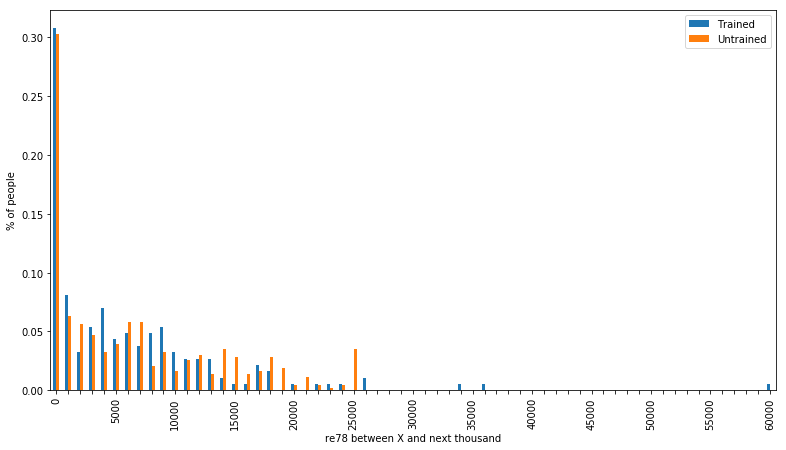

In [6]:
drawRe(data, data_NSW, data_PSID, 're78', 100).figure

We do now have a better idea of how the revenue is spread. It seems that the repartition of the revenue is *somewhat* equivalent to a constant factor, but let us use a box graph to get a clear sense of the difference in mean and outliers.

We will now create a box graph to analyse the 2 groups.

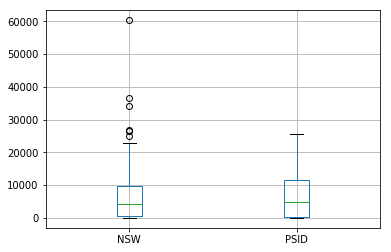

In [7]:
#We plot for figure 101
plt.figure(101).clear()

#get the earnings of 1978 and sort it
data_NSW_val = data_NSW['re78'].sort_values()
data_PSID_val = data_PSID['re78'].sort_values()

#create a dataframe to put into a graph (once again NSW = trained and PSID = untrained) 
fuse_Data_re78 = pd.DataFrame(data={'NSW' : data_NSW_val, 'PSID' : data_PSID_val})

#plot the graph
fuse_Data_re78.plot(kind='box', grid=True).figure

In this graph we can see that the PSID is a little better : it has a better 3rd quartile, a better median (we have calculated it before) and if we take out the outliers, it has a best maximum. NSW has a best 1st quartile but the difference is very minimal.

From what we have seen so far the untrained group is a little better.

So a naive "researcher" could say that the training does not help or even that it makes things worst.

In [8]:
#delete the figure from the cache so that too much figures would not create problem later.
plt.close('all')

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.


We will study the mean or percentage of each variable (depending if the variable is a absolute or a boolean).

In [9]:
#create the mean of the trained group for the variables
data_NSW[['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']].mean()

treat          1.000000
age           25.816216
educ          10.345946
black          0.843243
hispan         0.059459
married        0.189189
nodegree       0.708108
re74        2095.573689
re75        1532.055314
dtype: float64

In [10]:
#create the mean of the untrained group for the variables
data_PSID[['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']].mean()

treat          0.000000
age           28.030303
educ          10.235431
black          0.202797
hispan         0.142191
married        0.512821
nodegree       0.596737
re74        5619.236506
re75        2466.484443
dtype: float64

We can see that NSW as a generality is younger, more black, more hispanic, has spend as much time in school, have less chance to have a diploma and had less earning in 74 and 75.

We will now create graph for all the variable to have a better visualization.

Plot a graph for the distribution of age in the 2 groups. 

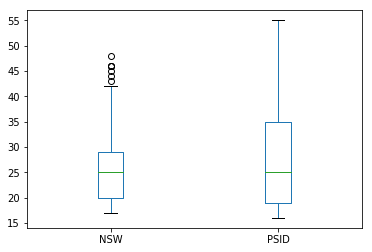

In [11]:
#We plot for figure 200
plt.figure(200).clear()
#plot the graph
pd.DataFrame(data={'NSW': data_NSW['age'], 'PSID': data_PSID['age']}).plot(kind='box').figure

Plot a graph for the distribution of year of education in the 2 groups. 

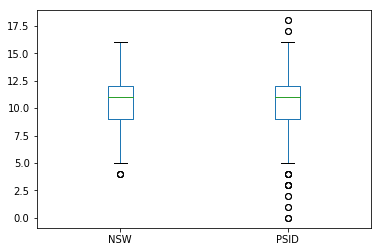

In [12]:
#We plot for figure 201
plt.figure(201).clear()
#plot the graph
pd.DataFrame(data={'NSW': data_NSW['educ'], 'PSID': data_PSID['educ']}).plot(kind='box').figure

Plot a graph for the distribution of earnings in 74 in the 2 groups. 

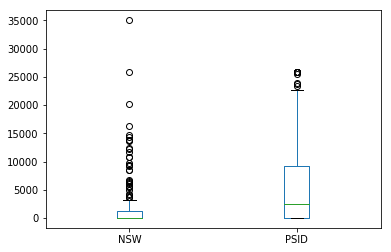

In [13]:
#We plot for figure 202
plt.figure(202).clear()
#plot the graph
pd.DataFrame(data={'NSW': data_NSW['re74'], 'PSID': data_PSID['re74']}).plot(kind='box').figure

Plot a graph for the distribution of earnings in 75 in the 2 groups. 

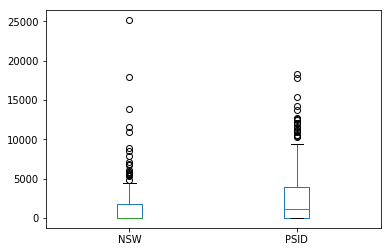

In [14]:
#We plot for figure 203
plt.figure(203).clear()
#plot the graph
pd.DataFrame(data={'NSW': data_NSW['re75'], 'PSID': data_PSID['re75']}).plot(kind='box').figure

Plot a graph for the percentage of married people in the 2 groups. 

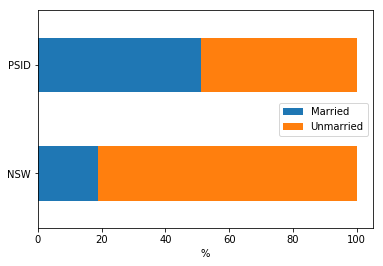

In [15]:
#We plot for figure 204
plt.figure(204).clear()

#create a dataframe of the trained group of the number of people married or not in it
married_NSW = data_NSW.married.value_counts().rename({1: "Married", 0: "Unmarried"})
#create a dataframe of the untrained group of the number of people married or not in it
married_PSID = data_PSID.married.value_counts().rename({1: "Married", 0: "Unmarried"})

#get the number of married and not married people to a percentage
married_NSW *= 100 / married_NSW.sum()
married_PSID *= 100 / married_PSID.sum()
#plot the graph
pd.DataFrame(data={'NSW': married_NSW, 'PSID': married_PSID}).T.plot(kind='barh', stacked=True).set_xlabel("%").figure

Plot a graph for the percentage of people with a diploma in the 2 groups.

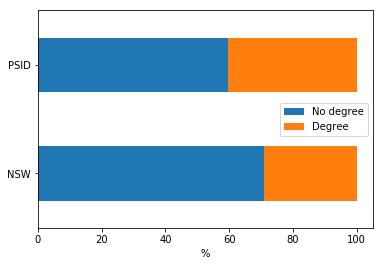

In [16]:
#We plot for figure 205
plt.figure(205).clear()

#create a dataframe of the trained group of the number of people having a diploma or not in it
degree_NSW = data_NSW.nodegree.value_counts().rename({1: "No degree", 0: "Degree"})
#create a dataframe of the untrained group of the number of people having a diploma or not in it
degree_PSID = data_PSID.nodegree.value_counts().rename({1: "No degree", 0: "Degree"})
#get the number of people having a diploma or not to a percentage
degree_NSW *= 100 / degree_NSW.sum()
degree_PSID *= 100 / degree_PSID.sum()
#plot the graph
pd.DataFrame(data={'NSW': degree_NSW, 'PSID': degree_PSID}).T.plot(kind='barh', stacked=True).set_xlabel("%").figure

Plot a graph for the distribution of skin colour between the people in the 2 groups.

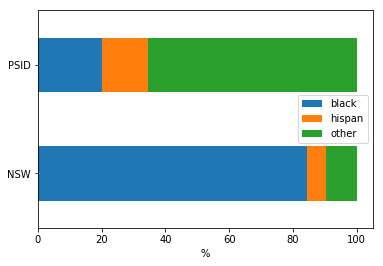

In [17]:
#We plot for figure 205
plt.figure(205).clear()

#get all the column for the races and sum its result getting the number of peope as desribed by the column for the trained group
race_NSW = data_NSW[data_NSW.columns[4:6]].sum()
#get all the column for the races and sum its result getting the number of peope as desribed by the column for the untrained group
race_PSID = data_PSID[data_PSID.columns[4:6]].sum()

#append to the 2 groups a final column for the races not talked about in the graph.
race_NSW = race_NSW.append(pd.Series(len(data_NSW) - race_NSW.sum(), index=["other"]))
race_PSID = race_PSID.append(pd.Series(len(data_PSID) - race_PSID.sum(), index=["other"]))

#transform the number of people of each race in a percentage
race_NSW *= 100 / race_NSW.sum()
race_PSID *= 100 / race_PSID.sum()
#plot the graph
pd.DataFrame(data={'NSW': race_NSW, 'PSID': race_PSID}).T.plot(kind='barh', stacked=True).set_xlabel("%").figure

From all those data we can confirm what we have seen with the means that NSW as a generality is younger, more black, more hispanic, has spent as much time in school, have less chance to have a diploma and had less earning in 74 and 75.

We can see that our 2 groups are widely different as people and at how much they were earning before the trainings.

For the analysis of the naive "researcher", we can see that the 2 groups being widely different might skew the results we have but worst we see that there is an enormous difference between the earnings before the training program, so the difference between the 2 groups do not mainly come from the training but from the old earnings, so those data can not be used to test a training program.

In [18]:
#delete the figure from the cache so that too much figures would not create problem later.
plt.close('all')

#### 3. A propsensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. It's sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)


As explained in the statement, we use linear_model.LogisticRegression from sklearn to create a logisticRegression model. Then, we compute the propensity score from the model for each person in the dataset.

In [20]:
#generate the logistic regression model
logistic_regressor = linear_model.LogisticRegression()

#train the regressor with the data we have
#we cast the re78 as int column because the logistic regressor cannot make a regression on continuous values 
logistic_regressor = logistic_regressor.fit(
    data[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']].values, \
    data['treat'].values.astype('int'))

#create a dataframe to have the propensity score in it
propensity_data = data.copy()

#add a column re78reg for the propensity score given by the logistic regressor
propensity_data['re78reg'] = logistic_regressor.predict_proba(
    data[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']].values)[:, 1]

propensity_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,group,re78reg
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,NSW,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,NSW,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,NSW,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,NSW,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,NSW,0.698286


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

This cell will create the matching between the trained and the untrained dataset. To do that we will use the method max_weight_matching from the library github that you can have more information [here](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.matching.max_weight_matching.html).

This method will take a graph and create a maximum cardinality matching using the weight of the edges. So, to use this, we will make the index of each element of the dataset a node, and we will link every trained index with every untrained index with an edge of weight 1 - absolute difference between the 2 earnings. The reason of this weight is this algorithm is maximizing the weight, and as we want to minimize it we just maximize its inverse (knowing that the idfference between the 2 probability is between 0 and 1).

In [21]:
#create the group of trained people in the dataSet with the propensity
propensity_NSW = propensity_data[(propensity_data['treat'] == 1)]
#create the group of untrained people in the dataSet with the propensity
propensity_PSID = propensity_data[(propensity_data['treat'] == 0)]

#the length of the new trained dataset
pNSW_length = len(propensity_NSW)
#the length of the new untrained dataset
pPSID_length = len(propensity_PSID)

#create the edges for the graph with weight as discussed in the markdown
edges = [(idx, idy, {'weight': 1 - abs(x['re78reg'] - y['re78reg'])}) \
         for (idx, x) in propensity_NSW.iterrows() for (idy, y) in propensity_PSID.iterrows()]

#create the graph
graph = nx.Graph()
#add the edges to the graph
graph.add_edges_from(edges)

#create the matching in the form of a dictionnary using the method we talked about
dico_matching = nx.max_weight_matching(graph, maxcardinality=True)

Now that we have a dictionnary, we can easily use the fact that the dictionnary has as index all the indexes of the matching to use it to filter the dataset to have only the person of the matching.

In [22]:
#filter to all the individual taht are in the matching
matched_data = propensity_data[propensity_data.index.isin(list(dico_matching))]
matched_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,group,re78reg
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,NSW,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,NSW,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,NSW,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,NSW,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,NSW,0.698286


In [23]:
#split the matched data
matched_NSW = matched_data[matched_data['treat'] == 1]
matched_PSID = matched_data[matched_data['treat'] == 0]

In [24]:
#the means of re78
matched_data.groupby('group').mean()['re78']

group
NSW     6349.143530
PSID    5312.474907
Name: re78, dtype: float64

In [25]:
#the medians of re78
matched_data.groupby('group').median()['re78']

group
NSW     4232.309
PSID    3392.860
Name: re78, dtype: float64

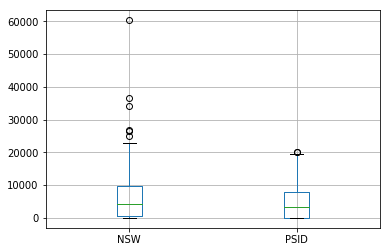

In [26]:
plt.figure(400).clear()
#the repartition of re74 in both groups
pd.DataFrame(data={'NSW': matched_NSW['re78'], 'PSID': matched_PSID['re78']}).plot(kind='box', grid=True).figure

In [27]:
#the means in NSW
matched_NSW[['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']].mean()

treat          1.000000
age           25.816216
educ          10.345946
black          0.843243
hispan         0.059459
married        0.189189
nodegree       0.708108
re74        2095.573689
re75        1532.055314
dtype: float64

In [28]:
#the means in PSID
matched_PSID[['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']].mean()

treat          0.000000
age           23.713514
educ          10.162162
black          0.470270
hispan         0.118919
married        0.167568
nodegree       0.627027
re74        2095.885961
re75        1615.306428
dtype: float64

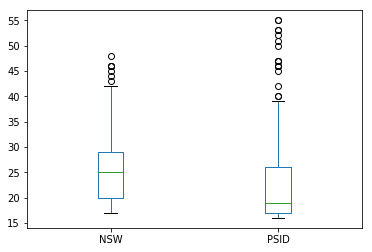

In [29]:
plt.figure(401).clear()
#the repartition of the age in both groups
pd.DataFrame(data={'NSW': matched_NSW['age'], 'PSID': matched_PSID['age']}).plot(kind='box').figure

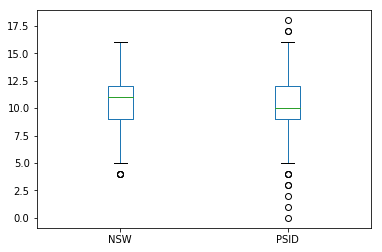

In [30]:
plt.figure(402).clear()
#the repartition of eduction years in both groups
pd.DataFrame(data={'NSW': matched_NSW['educ'], 'PSID': matched_PSID['educ']}).plot(kind='box').figure

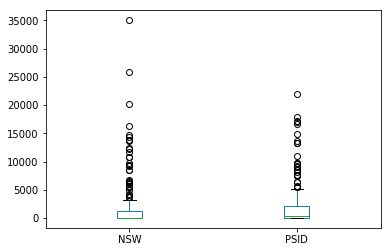

In [31]:
plt.figure(403).clear()
#the repartition of re74 in both groups
pd.DataFrame(data={'NSW': matched_NSW['re74'], 'PSID': matched_PSID['re74']}).plot(kind='box').figure

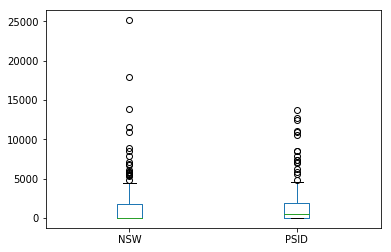

In [32]:
plt.figure(404).clear()
#the repartition of re75 in both groups
pd.DataFrame(data={'NSW': matched_NSW['re75'], 'PSID': matched_PSID['re75']}).plot(kind='box').figure

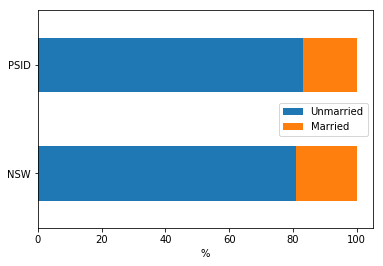

In [33]:
plt.figure(405).clear()
#we count values in both groups
married_NSW = matched_NSW.married.value_counts().rename({1: "Married", 0: "Unmarried"})
married_PSID = matched_PSID.married.value_counts().rename({1: "Married", 0: "Unmarried"})
#we turn them into percents
married_NSW *= 100 / married_NSW.sum()
married_PSID *= 100 / married_PSID.sum()
#we plot the results
pd.DataFrame(data={'NSW': married_NSW, 'PSID': married_PSID}).T.plot(kind='barh', stacked=True).set_xlabel("%").figure

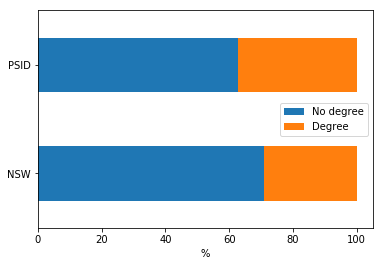

In [34]:
plt.figure(406).clear()
#we count values in both groups
degree_NSW = matched_NSW.nodegree.value_counts().rename({1: "No degree", 0: "Degree"})
degree_PSID = matched_PSID.nodegree.value_counts().rename({1: "No degree", 0: "Degree"})
#we turn them into percents
degree_NSW *= 100 / degree_NSW.sum()
degree_PSID *= 100 / degree_PSID.sum()
#we plot the results
pd.DataFrame(data={'NSW': degree_NSW, 'PSID': degree_PSID}).T.plot(kind='barh', stacked=True).set_xlabel("%").figure

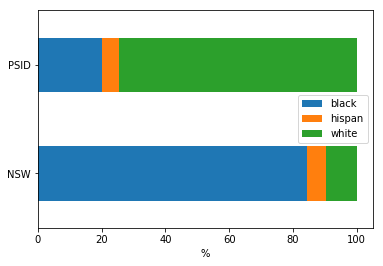

In [35]:
plt.figure(407).clear()
#we get the racial values
race_NSW = matched_NSW[data_NSW.columns[4:6]].sum()
race_PSID = matched_PSID[data_PSID.columns[4:6]].sum()
#we extract the number of white people
race_NSW = race_NSW.append(pd.Series(len(data_NSW) - race_NSW.sum(), index=["white"]))
race_PSID = race_PSID.append(pd.Series(len(data_PSID) - race_PSID.sum(), index=["white"]))
#we turn them into percents
race_NSW *= 100 / race_NSW.sum()
race_PSID *= 100 / race_PSID.sum()
#we plot the results
pd.DataFrame(data={'NSW': race_NSW, 'PSID': race_PSID}).T.plot(kind='barh', stacked=True).set_xlabel("%").figure

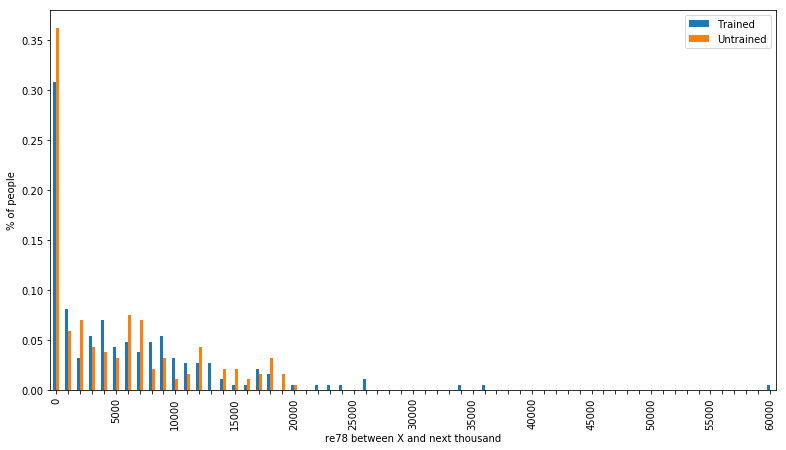

In [36]:
#the repartition of re78 for both groups
drawRe(matched_data, matched_NSW, matched_PSID, 're78', 408).figure

In [37]:
#delete the figure from the cache so that too much figures would not create problem later.
plt.close('all')

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


After the matching we have way closer values for the trained and untrained values before the training, the untrained still have a little better earning but as a whole it is as good as equal, so we are satisfied with the matching.

This being said the dataset is still not balanced, our main source of concern is that there is a enormous difference in the skin colour between the 2 groups which is a factor that might influence the earning (article on that [here](https://www.theguardian.com/society/2017/sep/26/race-pay-gap-not-just-us-problem-financial-inequality-uk)).

In [38]:
data5_list = [matched_data[(matched_data['treat'] == x) & (matched_data['black'] == int(y/2)) & (matched_data['hispan'] == y%2)] \
              for x in range(2) for y in range(3)]
groups_5 = ['black PSID', 'hispanic PSID', 'white PSID', 'black NSW', 'hispanic NSW', 'white NSW' ]

for_data_group = dict(zip(groups_5, data5_list))

We will not use the barplot from there because it would be impossible to read so we use only box plot.

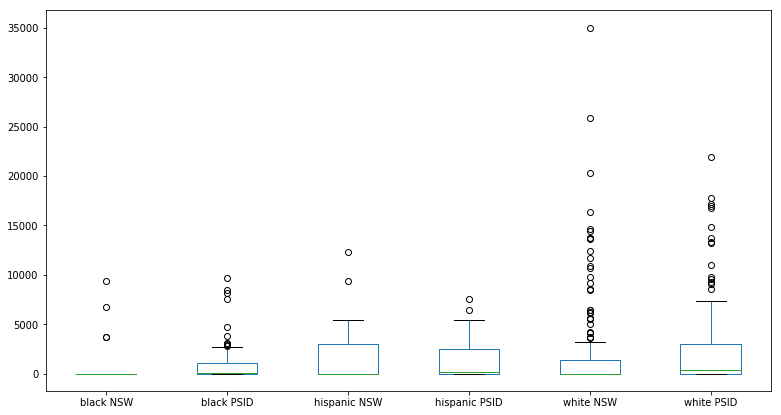

In [39]:
plt.figure(500).clear()
#the repartition of re74 for all three enthnicities in both groups
pd.DataFrame(data=dict(zip(groups_5, [x['re74'] for x in data5_list]))).plot(kind='box', figsize=(13, 7)).figure

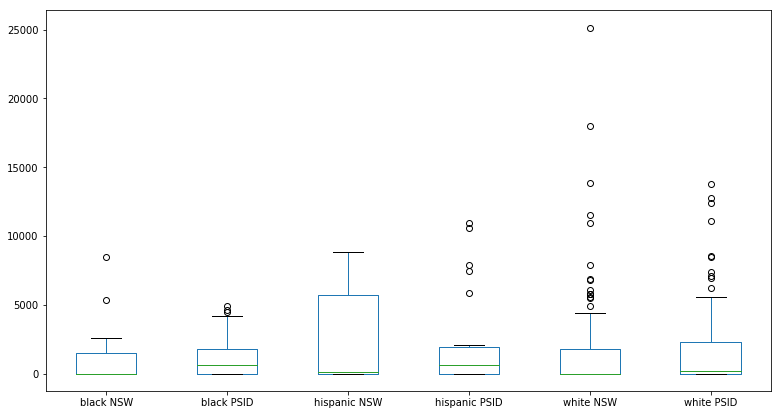

In [40]:
plt.figure(501).clear()
#the repartition of re75 for all three enthnicities in both groups
pd.DataFrame(data=dict(zip(groups_5, [x['re75'] for x in data5_list]))).plot(kind='box', figsize=(13, 7)).figure

We can see here some big differences between the different groups created by example in the earnings of year 74 we can see some extreme difference between the black NSW and the white PSID.

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [41]:
#the means
dict(zip(groups_5, [x['re78'].mean() for x in data5_list]))

{'black NSW': 7720.992277777778,
 'black PSID': 4922.248744736841,
 'hispanic NSW': 7122.515563636363,
 'hispanic PSID': 8475.836954545453,
 'white NSW': 6136.320646794871,
 'white PSID': 4853.431497126434}

In [42]:
#the medians
dict(zip(groups_5, [x['re78'].median() for x in data5_list]))

{'black NSW': 5998.226500000001,
 'black PSID': 3556.888,
 'hispanic NSW': 5112.014,
 'hispanic PSID': 7649.451499999999,
 'white NSW': 3879.584,
 'white PSID': 1613.6770000000001}

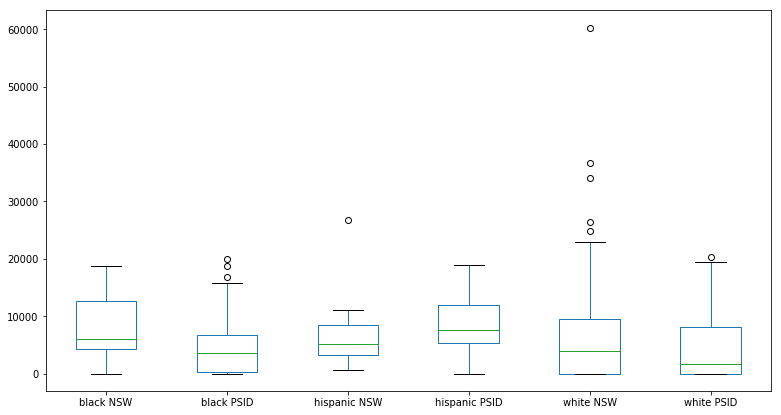

In [43]:
plt.figure(600).clear()
#the repartition of re78 for all three ethnicities and both groups
pd.DataFrame(data=dict(zip(groups_5, [x['re78'] for x in data5_list]))).plot(kind='box', figsize=(13, 7)).figure

Here we can see that in the black and white people groups the trained people have better earnings and in the hispanic group the untrained group has better earnings. However, kwnowing that there is not a lot of people in the hispanic group (less than  10%), we can consider that we lack data to have a good result with this group.

So now we can conclude that the training is improving the earning of an individual (especially in the black group).

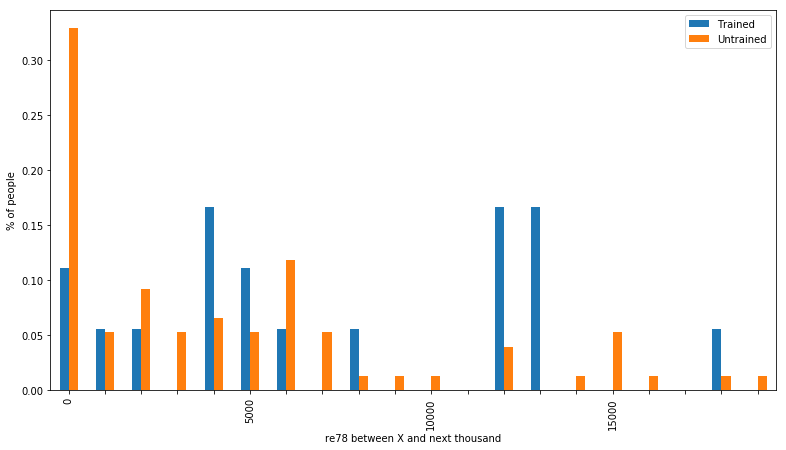

In [44]:
#For black people
drawRe(matched_data[matched_data['black'] == 1], data5_list[3], data5_list[0], 're78', 601).figure

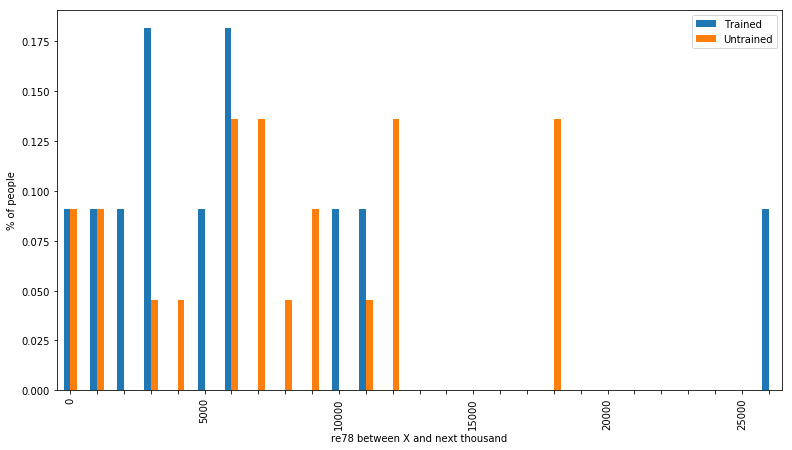

In [45]:
#For hispanic people
drawRe(matched_data[matched_data['hispan'] == 1], data5_list[4], data5_list[1], 're78', 602).figure

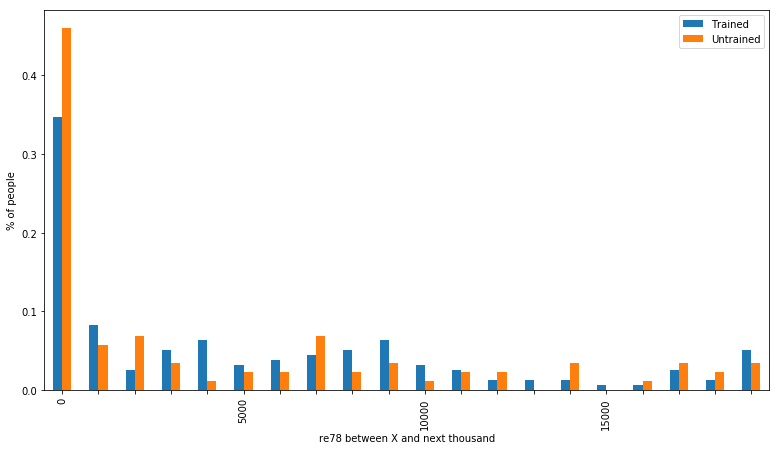

In [46]:
#For white people
drawRe(matched_data[(matched_data['black'] == 0) & (matched_data['hispan'] == 0)], data5_list[5], data5_list[2], 're78', 603).figure

In [47]:
#delete the figure from the cache so that too much figures would not create problem later.
plt.close('all')

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!


(1) Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequencyâ€“inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).



In [48]:
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from random import randrange
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from math import log10

We will now download the dataset using the method "fetch_20newsgroups" described in the link of the assignement. We will add some degree of randomness for later using the variable random_state of the method.

In [49]:
#download the group and save it in a file in our homework
newsgroups = fetch_20newsgroups(data_home='20newsgroups', subset='all', random_state=1)

Now using the TfidfVectorizer described in the assignement, we will now create the features using term frequency–inverse document frequency.

In [50]:
#create the vectorizer to be used to compute the features
tfid = TfidfVectorizer()
#compute the features of our dataset
news_tfid = tfid.fit_transform(newsgroups.data)

Now we will split our newly created TFID dataset in a 80-10-10 split. We do not need to randomize it as it was already randomized when we download it. We will also split the 'target' element of our initial database that represents the category that our model will try to predict. The two split will take the same part of the dataset so that the features match with their category.

In [51]:
#calculate the size of one tenth of the original dataset
one_tenth = int(len(newsgroups.data) / 10)
#transform the dataset into a matrix 
news_tfid_matrix = news_tfid.A

#take the 80% of the mid part of the feature matrix to create the the train dataset of features
nt_train = news_tfid_matrix[one_tenth:-one_tenth]
#take the 80% of the mid part of the target list to create the the train dataset of categories
cat_train = newsgroups['target'][one_tenth:-one_tenth]
#take the first one tenth of the feature matrix to create the test dataset of features
nt_test = news_tfid_matrix[:one_tenth]
#take the first one tenth of the target list to create the test dataset of categories
cat_test = newsgroups['target'][:one_tenth]
#take the last one tenth of the feature matrix to create the validation dataset of features
nt_validation = news_tfid_matrix[-one_tenth:]
#take the last one tenth of the target list to create the train validation of categories
cat_validation = newsgroups['target'][-one_tenth:]

(2) Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.


We will now try to find the best value for max_depth and n_estimators, because it would take too much time to try to find both at the same time, we will now try to find the best value of max_depth and once it is done, find the best value of n_estimators.

Note : with default value, the validation on the test set is 0.64012738853503182

Here we iterate different value, we use this value to give it to max_depth (with n_estimators being at its default value) to train our classifier and we next see how good it is by comparing the result of our model on the validation set  and the true categorie of the validation set. We have change the value in the range to find the most precise value and let it to the last range check.

In [52]:
#This code is not meant to be run as it would take too long to finish, it only show how we find our value.

'''
for i in range(10, 100, 10):
    classifier = RandomForestClassifier(max_depth=i)
    classifier.fit(nt_train, cat_train)
    print(i, classifier.score(nt_validation, cat_validation))
'''

'\nfor i in range(10, 100, 10):\n    classifier = RandomForestClassifier(max_depth=i)\n    classifier.fit(nt_train, cat_train)\n    print(i, classifier.score(nt_validation, cat_validation))\n'

Here are some different result for a max_depth value : 
Here are some different result for a max_depth value :
10 0.365711252654  
20 0.526539278132  
30 0.589171974522  
40 0.613588110403  
10 0.365711252654  
20 0.526539278132  
30 0.589171974522  
40 0.613588110403  
50 0.624203821656  
60 0.652866242038  
70 0.651804670913  
80 0.651804670913   

We can see that the maximum is attained at max_depth=60 and after that the score goes down and stop changing, so we will keep 60 for the best max_depth.

Here we iterate different value, we use this value to give it to n_estimators (with n_estimators being at 120) to train our classifier and we next see how good it is by comparing the result of our model on the validation set and the true categorie of the validation set. We have change the value in the range to find the most precise value and let it to the last range check.

In [53]:
#This code is not meant to be run as it would take too long to finish, it only show how we find our value.

'''
for i in range(10, 100, 10):
    classifier = RandomForestClassifier(max_depth=60, n_estimators=i)
    classifier.fit(nt_train, cat_train)
    print(i, classifier.score(nt_validation, cat_validation))
'''

'\nfor i in range(10, 100, 10):\n    classifier = RandomForestClassifier(max_depth=60, n_estimators=i)\n    classifier.fit(nt_train, cat_train)\n    print(i, classifier.score(nt_validation, cat_validation))\n'

10 0.624734607219  
20 0.724522292994  
30 0.763800424628  
40 0.779723991507  
50 0.799893842887  
60 0.805201698514  
70 0.820063694268   
80 0.819002123142   
90 0.826433121019  
100 0.829617834395   
150 0.82855626327   
200 0.842887473461   
250 0.846072186837 

We can see that the more estimators we use, the more good is our model. But the more estimators we use, the longer it takes to make the program runs so we will stop at 250 for the value of n_estimators (which takes around 5 hours to finish).

This is the part of the code where we train the true classifier, because it takes too much time, we will save it in a file and not make this part run after it is done.     
This code is not meant to be run as it would take too long to finish, it only show how we find our value.

In [54]:
#classifier = RandomForestClassifier(max_depth=60, n_estimators=250)
#classifier.fit(nt_train, cat_train)

#save the classifier in a file so that we can have it again without waiting hours.
#joblib.dump(classifier, 'classifier.pkl')

Load the classifier and predict the test dataset.     
Warning : you need to dezip the file classifier.pkl.zip for this part to work.

In [56]:
#load the classifier from classifier.pkl you need. You need to dezip the file classifier.pkl.zip for this part to work.
classifier = joblib.load('classifier.pkl') 
y_pred = classifier.predict(nt_test)

C:\Users\alain\Anaconda3\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\alain\Anaconda3\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Check how good our model is.

In [57]:
classifier.score(nt_test, cat_test)

0.84341825902335454

This is a pretty good score which show how good our parameters  are.

In [58]:
confusion_matrix(cat_test , y_pred)

array([[ 87,   1,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  13,   0,   1,   0,   2],
       [  1,  70,   5,   5,   1,   3,   6,   0,   0,   0,   0,   1,   1,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   1,  92,   4,   0,   5,   1,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   5,   4,  62,   0,   2,   4,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   6,   0,   7,  84,   0,   7,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   5,   2,   2,   0,  83,   1,   0,   0,   1,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   3,   1,   2,   0,  97,   2,   0,   0,   0,   0,   0,
          0,   1,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   1,   0,   6,  83,   1,   1,   0,   0,   1,
          1,   1,   0,   1,   0,   0,   0],
       [  0,   1,   0,   0,   1,   0,   3,   4,  96,   1,   0,  

As expected after having checked the precision of our model, we can see here that for most of the value the class given and the actual class match except for the 1st column where we can see that a pretty good part of the values mismatch, and the last column where most of the value mismatch.

Because the feature importances matrix is too big (around 200 000 elements) we can not just analyse it in its raw form, what we will do is analyse it by orders of magnitude. We will create an array where the 0th position is the number of elements with 0 feature importance and the ith element is the number of element with  a feature importance between 10^-i and 10^-(i+1).

Note that there is no feature with importance between 0 and 10^-1 so there is no conflict in the counting of the first cell and the minimum feature importance is of order 10^-10 which is why the size of the table is 10.

In [59]:
#the array of feature importance
feature_importance = classifier.feature_importances_
#the array we will use to store the results
nb_element_by_order = [0] * 10

#for all element of the feature importance array if it is 0 we put +1 at place 0 
#and else we put +1 at its order of magnitude
for x in feature_importance :
    if x == 0 :
        nb_element_by_order[0] += 1
    else :
        nb_element_by_order[int(-log10(x))] += 1

print(nb_element_by_order)

[118273, 0, 128, 1667, 7407, 28938, 13893, 2708, 693, 55]


We are know going to look at how important are the best 0.1% (around 174) to the model

In [60]:
sort_feature_importance = sorted(feature_importance)
sum(sort_feature_importance[-174:])

0.26431215253438234

We can see that most of the element (around 2/3) has no importance and a lot have very few importance. On the other hand we can see that the best 0.1% features make 25% of the importance of the model.

This means that for the classifier, most of the elements are of no importance and that only a litle number of case allow him to build the tree.